# **Consommation et revenu disponible brut des ménages français depuis 1949**

Il est temps de mettre en pratique ce qui a été vu sur les séries temporelles via un petit projet guidé d'analyse de séries temporelles.

L'objectif est de s'intéresser à la relation entre les dépenses de consommation et le revenu disponible des ménages en France. Pour ce faire, on distinguera trois parties :
1. [l'acquisition des données](#donnees)
2. [la modélisation univariée à partir d'une spécification ARIMA](#arima)
3. [l'existence d'une relation de long terme et d'un modèle à correction d'erreur](#extra) : ça, ça risque d'être un peu plus coton parce qu'on en a pas parlé et que c'est tout simplement plus dur, mais pour les plus rapides, peut-être vous aurez le temps de vous penchez dessus et sinon je vous ferai une correction que vous sachiez à quoi ça correspond.

Vous trouverez dans le dossier data, les series suivantes nécéssaires à votre travail :
- la série de [consommation des ménages aux prix courants](https://www.insee.fr/fr/statistiques/4485021?sommaire=4485040)
- la série du [revenu disponible brut des ménages aux prix courants](https://www.insee.fr/fr/statistiques/4485029?sommaire=4485040) (souvent abrégé *RDB*)
- vous aurez également besoin des [indices de prix à la consommation](https://www.insee.fr/fr/metadonnees/source/indicateur/p1653/description) pour transformer en valeurs réelles les séries qui sont en valeurs nominales.

<a id="donnees"></a>

## **Partie 1 - Les données**

In [1]:
#vos imports
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import shapiro
import warnings ; warnings.filterwarnings(action='ignore') #pour ignorer les warnings : privilégier en général action="once" pour n'avoir qu'une fois les warnings

### **Question 1.1**

Importer les 2 séries en gérant bien les dates afin d'avoir un DatetimeIndex de frequence trimestriel.

In [2]:
conso = pd.read_csv('data/conso.csv', decimal=",")
conso = pd.DataFrame(data=conso.conso.values,
                    index=pd.date_range(start="1949", end="2020", freq="Q")[:-3],
                    columns=["conso"])
conso

,conso
1949-03-31,1.9
1949-06-30,2.0
1949-09-30,2.1
1949-12-31,2.1
1950-03-31,2.1
...,...
2018-03-31,303.4
2018-06-30,304.2
2018-09-30,306.5
2018-12-31,307.3


In [3]:
rdb = pd.read_csv('data/revenu.csv', decimal=",")
rdb = pd.DataFrame(data=rdb.rdb.values,
                    index=pd.date_range(start="1949", end="2020", freq="Q"),
                    columns=["rdb"])
rdb

,rdb
1949-03-31,2.3
1949-06-30,2.3
1949-09-30,2.4
1949-12-31,2.4
1950-03-31,2.5
...,...
2018-12-31,361.2
2019-03-31,363.9
2019-06-30,364.9
2019-09-30,367.4


### **Question 1.2**

Qu'appelle-t-on "valeur nominale" et "valeur réelle" ?  
En quelles valeurs sont les séries dont vous disposez ? La réponse est dans l'énoncé...  
Quelles valeurs vous paraissent plus adaptées au problème ?  
Faire la transformation nécessaire (vous disposez de la série des indices de prix à la consommation, ça peut servir)

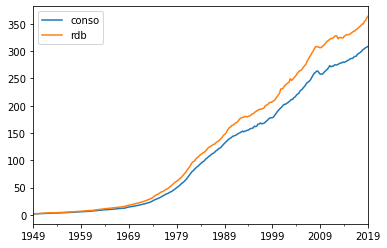

In [4]:
df = conso
df["rdb"] = rdb.rdb.values[:-3]
df.plot();

In [5]:
df["ipc"] = pd.read_csv("data/ipc.csv", usecols=["indice"]).values[:-3]
df.head()

,conso,rdb,ipc
1949-03-31,1.9,2.3,5.07
1949-06-30,2.0,2.3,4.91
1949-09-30,2.1,2.4,5.15
1949-12-31,2.1,2.4,5.38
1950-03-31,2.1,2.5,5.46


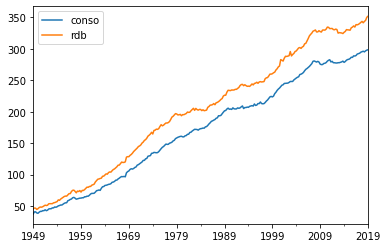

In [6]:
df.conso = df.conso/df.ipc*100
df.rdb = df.rdb/df.ipc*100
df[["conso", "rdb"]].plot();

### **Question 1.3**


Représentez graphiquement les 2 séries avec et sans transformation logarithmique.  
Que constate-t-on ?  
Laquelle vous semble-t-elle le plus adéquate ?

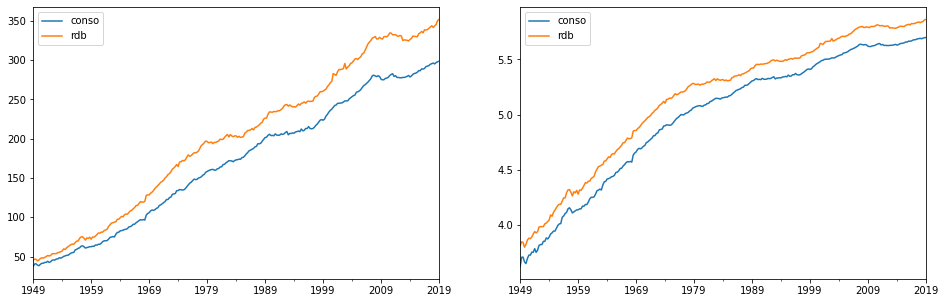

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
df[["conso", "rdb"]].plot(ax=ax1);
np.log(df)[["conso", "rdb"]].plot(ax=ax2);

### **Question 1.4**

La série est-t-elle stationnaire ?  
Pour ceux que ça intéresserait (y a un peu de maths derrière par contre...), il existe des tests pour déterminer si une série est stationnaire lorsque ce n'est pas évident graphiquement. Il en existe de 2 sortes :
- les tests de stationnarité, comme le test KPSS, pour lesquels l'hypothèse nulle $H_0$ est que la série est stationnaire
- les tests de racine unitaire comme le test de Dickey-Fuller, le test augmenté de Dickey-Fuller (ADF), ou encore le test de Phillips-Perron (PP) pour lesquels l'hypothèse nulle $H_0$ est que la série a été générée par un processus présentant une racine unitaire, et donc, qu'elle n'est pas stationnaire

In [8]:
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(df.conso)[1],
      "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(df.conso)[1])

test ADF, HO: série non stationnaire : 0.9273887417939749 
test KPSS, HO: série stationnaire : 0.01


<a id="arima"></a>

## **Partie 2 - Modèle ARIMA**

Il est temps de modéliser ces séries par un modèle ARIMA : dans un premier temps, la série consommation puis il conviendra de répéter les opérations pour la série revenu disponible.

### **Question 2.1**

Se ramener à une série stationnaire par différenciation.

In [9]:
logC = np.log(df.conso)
logC.index

DatetimeIndex(['1949-03-31', '1949-06-30', '1949-09-30', '1949-12-31',
               '1950-03-31', '1950-06-30', '1950-09-30', '1950-12-31',
               '1951-03-31', '1951-06-30',
               ...
               '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31'],
              dtype='datetime64[ns]', length=281, freq='Q-DEC')

test ADF, HO: série non stationnaire : 0.028336611337233083 
test KPSS, HO: série stationnaire : 0.01


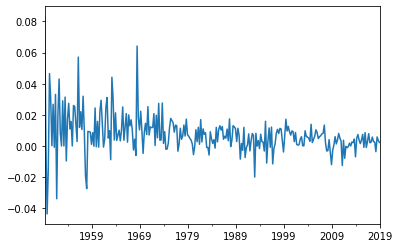

In [10]:
logC_diff = logC.diff()[1:] #exactement pareil que logC-logC.shift(1)
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(logC_diff)[1],
      "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(logC_diff, nlags='auto')[1])
logC_diff.plot();

test ADF, HO: série non stationnaire : 9.999794244454926e-08 
test KPSS, HO: série stationnaire : 0.1


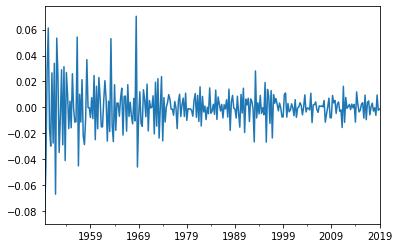

In [11]:
logC_diff2 = logC.diff().diff()[2:]
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(logC_diff2)[1],
      "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(logC_diff2, nlags='auto')[1])
logC_diff2.plot();

### **Question 2.2**

Proposer un ordre de grandeur maximum pour les parties *autorégressive* et *moyenne mobile*, c'est-à-dire pour les valeurs $p_{max}$ et $q_{max}$ du modèle $ARMA(p,q)$.

**Indication :** La détermination de bornes supérieures concernant l'ordre de la partie AR et de la partie MA passe par l'étude des autocorrélogrammes et des autocorrélogrammes partiels. En effet, si la série suit un modèle $ARMA(p,q)$, l'autocorrélogramme devient nul à partir du rang $q$ et l'autocorrélogramme partiel devient nul à partir du rang $p$. Dès lors, en se basant sur les autocorrélogrammes, il est possible de déterminer empiriquement les ordres maximum en regardant à partir de quel rang les autocorrélogrammes sont statistiquement nuls.

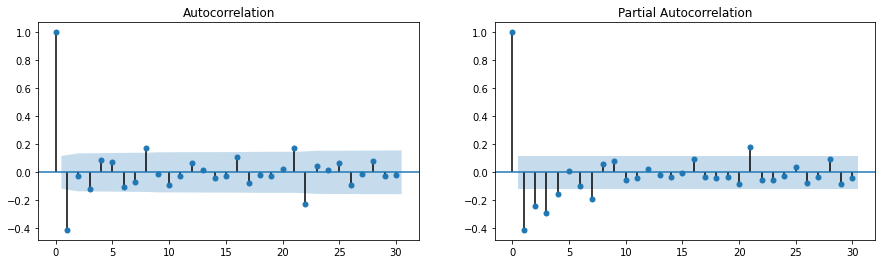

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
a = smt.graphics.plot_acf(logC_diff2, lags=30, ax=ax1, alpha=0.05)
b = smt.graphics.plot_pacf(logC_diff2, lags=30, ax=ax2, alpha=0.05)

### **Question 2.3**

Déterminer, à l'aide du critère $AIC$ (vous pouvez aussi utiliser le critère $BIC$), le ou les modèles les plus pertinents.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# valeurs possibles des paramètres
p = range(5)
q = range(2)

best_aic = np.inf
best_p = None
best_q = None
tmp_model = None
best_model = None

for p,q in itertools.product(p, q):
    try:
        tmp_model = ARIMA(logC, order = (p,2,q))
        res = tmp_model.fit()
        
        if res.aic < best_aic:
            best_aic = res.aic
            best_p = p
            best_q = q
            best_model = tmp_model
        print(f"Modèle testé : ARIMA({p},2,{q}) - AIC:{res.aic} - BIC:{res.bic}")
        
    except:
        print("Erreur:", sys.exc_info()[1])
        continue
            
print(f"Modèle retenu : ARIMA({best_p},2,{best_q}) - AIC:{best_aic}")

Modèle testé : ARIMA(0,2,0) - AIC:-1494.01480216562 - BIC:-1490.3835903837987
Modèle testé : ARIMA(0,2,1) - AIC:-1668.6021531514255 - BIC:-1661.3397295877828
Modèle testé : ARIMA(1,2,0) - AIC:-1548.9481052588756 - BIC:-1541.685681695233
Modèle testé : ARIMA(1,2,1) - AIC:-1663.4298997127867 - BIC:-1652.5362643673225
Modèle testé : ARIMA(2,2,0) - AIC:-1576.9865061319501 - BIC:-1566.092870786486
Modèle testé : ARIMA(2,2,1) - AIC:-1672.8387849406367 - BIC:-1658.3139378133512
Modèle testé : ARIMA(3,2,0) - AIC:-1628.6824335659053 - BIC:-1614.1575864386198
Modèle testé : ARIMA(3,2,1) - AIC:-1658.965543995842 - BIC:-1640.809485086735
Modèle testé : ARIMA(4,2,0) - AIC:-1648.0448898893615 - BIC:-1629.8888309802546
Modèle testé : ARIMA(4,2,1) - AIC:-1658.6332923378568 - BIC:-1636.8460216469286
Modèle retenu : ARIMA(2,2,1) - AIC:-1672.8387849406367


### **Question 2.4**

Pour valider les modèles  retenus, il reste deux critères à regarder :
1. regarder la significativité des coefficients
2. examiner la "blancheur" des résidus

In [15]:
# modèle retenu
res = ARIMA(logC, order=(2,2,1)).fit()

# équivalent avec un modèle SARIMA :
#from statsmodels.tsa.statespace.sarimax import *
#res = SARIMAX(logC, order=(2,2,1)).fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  conso   No. Observations:                  281
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 840.419
Date:                Wed, 10 Jun 2020   AIC                          -1672.839
Time:                        16:48:51   BIC                          -1658.314
Sample:                    03-31-1949   HQIC                         -1667.012
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0817      0.041     -2.006      0.045      -0.161      -0.002
ar.L2         -0.1770      0.040     -4.410      0.000      -0.256      -0.098
ma.L1         -0.9487      0.032    -29.473      0.0

test ADF, HO: série non stationnaire : 6.152626924525186e-07 
test KPSS, HO: série stationnaire : 0.1
Test de Shapiro : (0.836301863193512, 1.7056574080428778e-16)


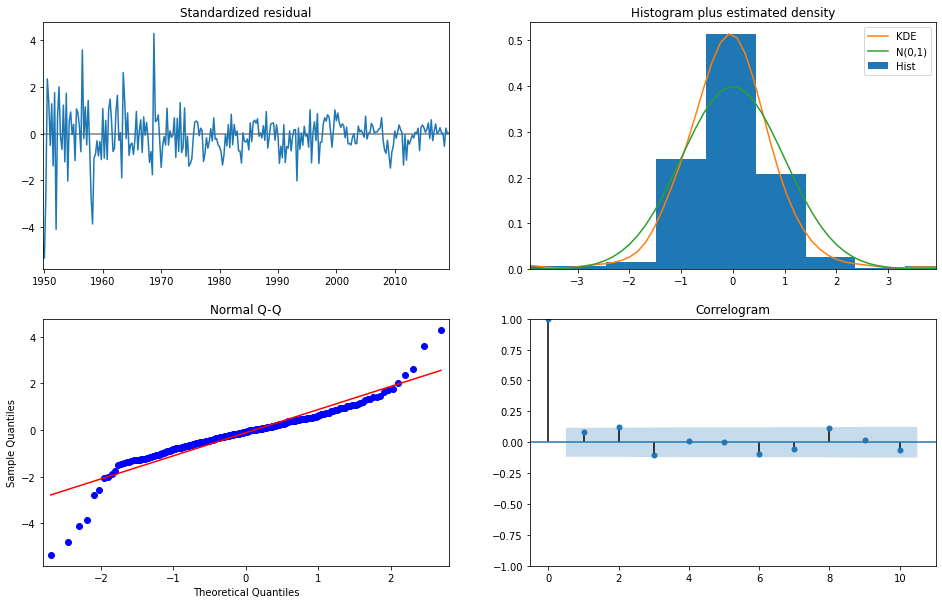

In [16]:
# résidus
err = res.resid[2:]
#stationnarité
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(err)[1],
      "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(err, nlags='auto')[1])
#normalité
print("Test de Shapiro :", shapiro(res.resid[2:]))
#affichage
res.plot_diagnostics(figsize=(16, 10));

### **Question 2.5**

Répéter l'analyse pour la série des revenus disponibles.

In [17]:
logR = np.log(df.rdb)

test ADF, HO: série non stationnaire : 0.010763127217824218 
test KPSS, HO: série stationnaire : 0.01


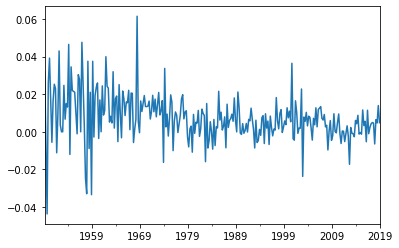

In [18]:
logR_diff = logR.diff()[1:]
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(logR_diff)[1], "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(logR_diff, nlags='auto')[1])
logR_diff.plot();

test ADF, HO: série non stationnaire : 2.834275816347393e-13 
test KPSS, HO: série stationnaire : 0.1


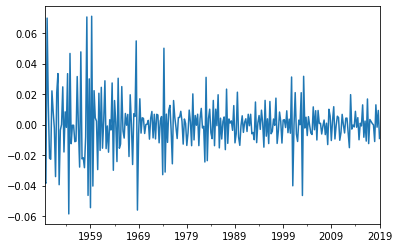

In [19]:
logR_diff2 = logR.diff().diff()[2:]
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(logR_diff2)[1], "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(logR_diff2, nlags='auto')[1])
logR_diff2.plot();

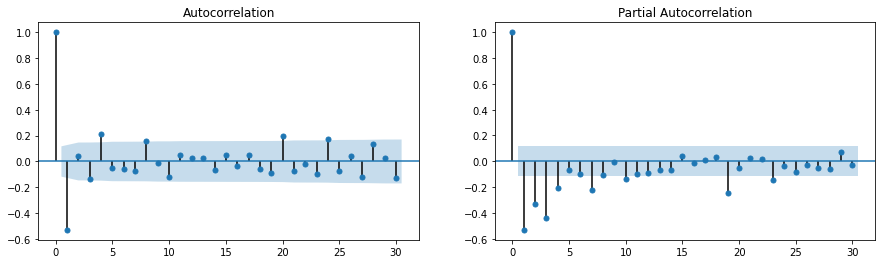

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
a = smt.graphics.plot_acf(logR_diff2, lags=30, ax=ax1, alpha=0.05)
b = smt.graphics.plot_pacf(logR_diff2, lags=30, ax=ax2, alpha=0.05)

In [21]:
# valeurs possibles des paramètres
p = range(5)
q = range(5)

best_aic = np.inf
best_p = None
best_q = None
tmp_model = None
best_model = None

for p,q in itertools.product(p, q):
    try:
        tmp_model = ARIMA(logR, order = (p,2,q))
        res = tmp_model.fit()
        
        if res.aic < best_aic:
            best_aic = res.aic
            best_p = p
            best_q = q
            best_model = tmp_model
        print(f"Modèle testé : ARIMA({p},2,{q}) - AIC:{res.aic} - BIC:{res.bic}")
        
    except:
        print("Erreur:", sys.exc_info()[1])
        continue
            
print(f"Modèle retenu : ARIMA({best_p},2,{best_q}) - AIC:{best_aic}")

Modèle testé : ARIMA(0,2,0) - AIC:-1449.510532943329 - BIC:-1445.8793211615077
Modèle testé : ARIMA(0,2,1) - AIC:-1653.0709475713481 - BIC:-1645.8085240077055
Modèle testé : ARIMA(0,2,2) - AIC:-1655.090740663273 - BIC:-1644.1971053178088
Modèle testé : ARIMA(0,2,3) - AIC:-1666.6553512323908 - BIC:-1652.1305041051053
Modèle testé : ARIMA(0,2,4) - AIC:-1665.14549288117 - BIC:-1646.9894339720631
Modèle testé : ARIMA(1,2,0) - AIC:-1540.8206719098253 - BIC:-1533.5582483461826
Modèle testé : ARIMA(1,2,1) - AIC:-1666.39437896138 - BIC:-1655.5007436159158
Modèle testé : ARIMA(1,2,2) - AIC:-1662.8397166185403 - BIC:-1648.3148694912547
Modèle testé : ARIMA(1,2,3) - AIC:-1663.7793443060036 - BIC:-1645.6232853968968
Modèle testé : ARIMA(1,2,4) - AIC:-1666.7541120779995 - BIC:-1644.9668413870713
Modèle testé : ARIMA(2,2,0) - AIC:-1577.9486851308397 - BIC:-1567.0550497853756
Modèle testé : ARIMA(2,2,1) - AIC:-1666.8851513510522 - BIC:-1652.3603042237667
Modèle testé : ARIMA(2,2,2) - AIC:-1662.420688

In [24]:
# modèle retenu
res = ARIMA(logC, order=(3,2,1)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  conso   No. Observations:                  281
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 834.483
Date:                Wed, 10 Jun 2020   AIC                          -1658.966
Time:                        16:55:37   BIC                          -1640.809
Sample:                    03-31-1949   HQIC                         -1651.682
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3309      0.076     -4.378      0.000      -0.479      -0.183
ar.L2         -0.4002      0.057     -7.044      0.000      -0.512      -0.289
ar.L3         -0.3730      0.048     -7.776      0.0

test ADF, HO: série non stationnaire : 9.508853654770824e-17 
test KPSS, HO: série stationnaire : 0.1
Test de Shapiro : (0.8548425436019897, 1.6814675499676138e-15)


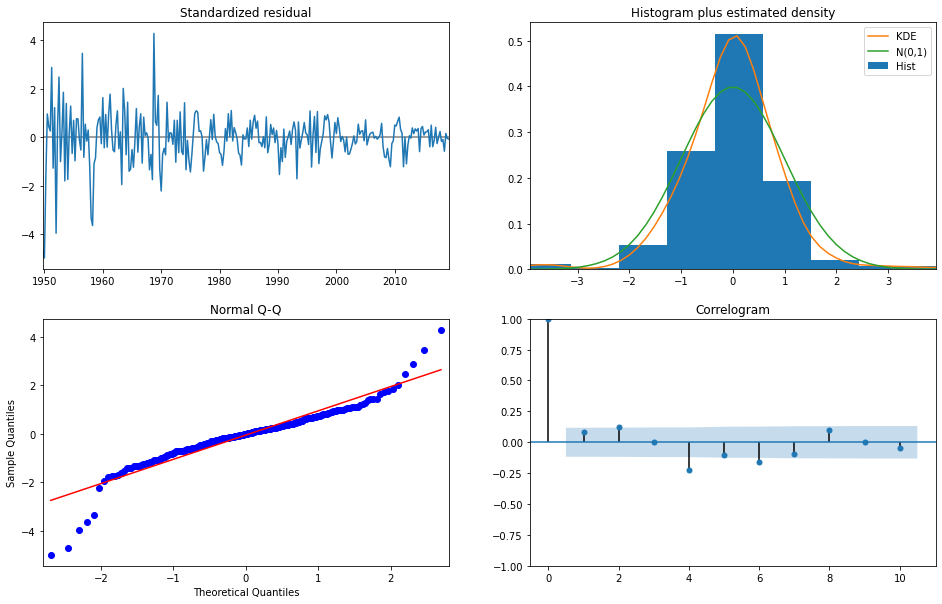

In [25]:
# résidus
err = res.resid[2:]
#stationnarité
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(err)[1],
      "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(err, nlags='auto')[1])
#normalité
print("Test de Shapiro :", shapiro(res.resid[2:]))
#affichage
res.plot_diagnostics(figsize=(16, 10));

<a id="extra"></a>

## **Partie 3 - Cointégration et modèle à correction d'erreur**

On s'intéresse dans cette partie au lien qu'il semble exister entre nos deux séries. En effet, graphiquement, les 2 séries ont l'air d'être liées par une relation de long terme. Plus spécifiquement, on suppose ici qu'il existe une éventuelle relation de **cointégration** de manière à mettre en place, par la suite, un modèle à **correction d'erreur**, ce qu'on ne fera pas ici.

On parle de cointégration lorsque les deux séries sont intégrées d’ordre 1 (c'est-à-dire que leur différenciation une fois : la série $x_t-x_{t-1}$ est stationnaire) et qu'il existe une relation linéaire entre les deux qui soit non intégrée (ou encore intégrée d'ordre zéro ou stationnaire, tout ça c'est à peu près pareil).

Sans forcément aller trop loin sur la partie théorique, juste 2 petites questions guidées permettent de regarder en pratique un début de ce qu'est la cointégration des séries.

### **Question 3.1**

Sous réserve de validation, la relation de long-terme est modélisée par un modèle linéaire. On va commencer par effectuer une régression linéaire de la série consommation, notée $C_t$ sur la série revenu disponible notée $R_t$ (avec ou sans transformation logarithmique selon l'étude qui a précédée) :

$$C_t = \beta_0 + \beta_1 R_t + z_t$$

Utiliser pour cette régression la libraire `statsmodel` afin afficher le `summary` de la régression puis commenter les résultats (notamment la significativité et les valeurs des coefficients)

In [26]:
res = sm.OLS(logC, sm.add_constant(logR)).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  conso   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.222e+05
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:57:10   Log-Likelihood:                 599.27
No. Observations:                 281   AIC:                            -1195.
Df Residuals:                     279   BIC:                            -1187.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2328      0.015    -15.509      0.0

### **Question 3.2**

Pour valider le modèle de cointégration, les résidus $z_t$ de la régression linéaire doivent être stationnaire. On peut regarder déjà graphiquement ce qu'il en est. Commenter le résultat.

Sans entrer dans le détail des tests de stationnarité évoqués précédemment, un peut utiliser par exmple la fonction `adfuller` du module `statsmodels.tsa.stattools` pour vérifier si la série est stationnaire. L'hypothèse nulle $H_0$ du test ADF est que la série admet ce qu'on appelle une racine unitaire et donc que la série n'est pas stationnaire.

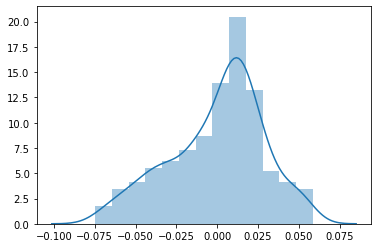

In [27]:
z = res.resid
sns.distplot(z);

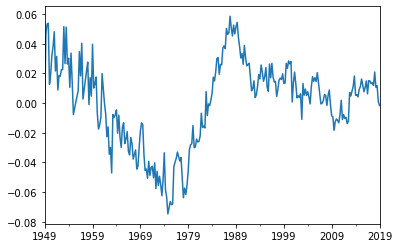

In [28]:
z.plot();

In [29]:
print("test ADF, HO: série non stationnaire :", smt.stattools.adfuller(z)[1],
      "\ntest KPSS, HO: série stationnaire :", smt.stattools.kpss(z, nlags='auto')[1])

test ADF, HO: série non stationnaire : 0.2641063126845302 
test KPSS, HO: série stationnaire : 0.07961723346181164


**Pour aller plus loin :** si vous souhaitez pousser l'analyse, vous pouvez vous intéresser à ce qu'on appelle un modèle à correction d'erreurs et essayer de comprendre la notion de vitesse d'ajustement. Pour cela, il faut, entre autres, modéliser les résidus par un processus $ARMA$.